In [1]:
from theFuncs import *

# DATA

In [2]:
# load_DTB3_SPY().to_csv('./data/spy_dtb3.csv')

In [3]:
sp100 = os.listdir(os.getcwd()+'/data/stock_dfs')
sp100_tickers = []
for csvfile in sp100:
    sp100_tickers.append(csvfile[:-4])

# sp100_tickers

In [4]:
ticker_data = get_ticker_data_multisource(
    sp100_tickers, 
    start="2019-01-02", 
    end="2021-11-01"
)
#start=2019-01-02
#end=2021-11-01

In [5]:
# nyse_tickers_cap = pd.read_csv("data/tickers_nyse.csv", index_col=0).MarketCap.dropna().apply(
#     lambda x: float(x[1: -1]) * 1e6 if x[-1] == "M" else float(x[1: -1]) * 1e6
# ).sort_values(ascending=False)[:200]

# nyse_tickers = nyse_tickers_cap.index

In [6]:
# nyse_ticker_weights = nyse_tickers_cap / nyse_tickers_cap.sum()
# nyse_ticker_weights.head()

In [7]:
# ticker_data = get_ticker_data_multisource(nyse_tickers)

In [8]:
tickers = sp100_tickers

model = RollingOLS.from_formula(
        "(ret - DTB3) ~ (spy_ret - DTB3)", 
        data = ticker_data.loc[tickers[0]], 
        window = 66
    ).fit(params_only=True)
df = model.params
df.columns = ["alpha", "Beta"]
df['ticker'] = tickers[0]
df.set_index('ticker', inplace=True, append=True)
df = df.reorder_levels(['ticker', 'date']).sort_index()


for ticker in tickers[1:]:
    try:
        model = RollingOLS.from_formula(
            "(ret - DTB3) ~ (spy_ret - DTB3)", 
            data = ticker_data.loc[ticker], 
            window = 66
        ).fit(params_only=True)

        temp = model.params
        temp.columns = ["alpha", "Beta"]
        temp['ticker'] = ticker
        temp.set_index('ticker', inplace=True, append=True)
        temp = temp.reorder_levels(['ticker', 'date']).sort_index()
        df = pd.concat(
            [ 
                df, 
                temp
            ]
        )
    except:
        continue

ticker_data = ticker_data.join(df)

ticker_data.head()

high        low       open      close       volume  \
ticker date                                                                  
AAPL   2019-01-03  36.430000  35.500000  35.994999  35.547501  365248800.0   
       2019-01-04  37.137501  35.950001  36.132500  37.064999  234428400.0   
       2019-01-07  37.207500  36.474998  37.174999  36.982498  219111200.0   
       2019-01-08  37.955002  37.130001  37.389999  37.687500  164101200.0   
       2019-01-09  38.632500  37.407501  37.822498  38.327499  180396400.0   

                        ret   spy_close    DTB3   spy_ret  alpha  Beta  
ticker date                                                             
AAPL   2019-01-03 -0.099607  232.998627  0.0236 -0.023863    NaN   NaN  
       2019-01-04  0.042689  240.803085  0.0237  0.033496    NaN   NaN  
       2019-01-07 -0.002226  242.701736  0.0241  0.007885    NaN   NaN  
       2019-01-08  0.019063  244.981995  0.0241  0.009395    NaN   NaN  
       2019-01-09  0.016982  246.126907  0.0240  0.004673    NaN   NaN

In [9]:
market_caps = pd.DataFrame(
    ticker_data.close * ticker_data.volume,
    columns=["MarketCap"]
)
market_caps.head()

MarketCap
ticker date                    
AAPL   2019-01-03  1.298368e+10
       2019-01-04  8.689088e+09
       2019-01-07  8.103280e+09
       2019-01-08  6.184564e+09
       2019-01-09  6.914143e+09

In [10]:
market_caps = market_caps.ewm(66).mean()

In [11]:
market_caps.head()

MarketCap
ticker date                    
AAPL   2019-01-03  1.298368e+10
       2019-01-04  1.082024e+10
       2019-01-07  9.900934e+09
       2019-01-08  8.950780e+09
       2019-01-09  8.531111e+09

In [12]:
ticker_data_wide = ticker_data.reset_index(level=['ticker', 'date'])
ticker_data_wide = ticker_data_wide[['ticker', 'date', 'ret']].pivot(
    index='date', 
    columns='ticker', 
    values='ret'
)
ticker_data_wide.head()

ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.099607,-0.032949,-0.047194,-0.034142,-0.039498,-0.021959,-0.015216,0.005997,-0.025242,-0.088951,...,-0.027270,-0.037016,-0.028392,-0.014024,-0.036037,0.003570,-0.010435,-0.007882,-0.005142,-0.015354
2019-01-04,0.042689,0.032217,0.028541,0.038884,0.048632,0.036903,0.034184,0.003995,0.050064,0.009828,...,0.011695,0.038514,0.034833,0.024726,0.043081,0.002490,0.033269,0.029633,0.006246,0.036870
2019-01-07,-0.002226,0.014595,0.014976,0.003473,0.013573,0.005724,0.013457,0.006190,0.034353,0.020366,...,0.001920,0.006241,-0.003376,-0.004698,0.018032,0.006388,0.005750,-0.006465,0.011772,0.005200
2019-01-08,0.019063,0.004648,-0.012006,0.025290,0.014918,0.003959,0.012824,0.011300,0.016612,-0.008026,...,0.013371,0.087270,0.000103,0.006436,0.005439,0.029267,0.020009,-0.002099,0.006981,0.007271
2019-01-09,0.016982,-0.032823,0.016691,0.005030,0.011819,0.014543,-0.001196,-0.008753,0.001714,0.043250,...,0.001439,-0.002587,0.005132,0.010659,0.011769,-0.022782,0.012050,0.005469,-0.003256,0.005275


In [13]:
rolling_correlations = ticker_data_wide.rolling(66).corr().fillna(0)
rolling_correlations.head()

ticker             AAPL  ABBV  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  \
date       ticker                                                           
2019-01-03 AAPL     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABBV     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABT      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ACN      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ADBE     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   

ticker             ...  UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker  ...                                                    
2019-01-03 AAPL    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABBV    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 101 columns]

In [14]:
filter_correlations = rolling_correlations.groupby(["date"]).sum().sum(axis=1)
filter_correlations_dates = filter_correlations[filter_correlations > 0].index
rolling_correlations = rolling_correlations.loc[filter_correlations_dates]

In [15]:
rolling_covariances = ticker_data_wide.rolling(66).cov().fillna(0)
rolling_covariances.head()

ticker             AAPL  ABBV  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  \
date       ticker                                                           
2019-01-03 AAPL     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABBV     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABT      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ACN      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ADBE     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   

ticker             ...  UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker  ...                                                    
2019-01-03 AAPL    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABBV    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 101 columns]

In [16]:
filter_covariances = rolling_covariances.groupby(["date"]).sum().sum(axis=1)
filter_covariances_dates = filter_covariances[filter_covariances > 0].index
rolling_covariances = rolling_covariances.loc[filter_covariances_dates]

In [17]:
rolling_covariances.loc[('2019-06-24', 'AAPL'), 'AAPL']

date        ticker
2019-06-24  AAPL      0.000275
Name: AAPL, dtype: float64

In [18]:
# ticker_data.to_csv("data/test_run/ticker_data.csv")
# ticker_data_wide.to_csv("data/test_run/ticker_data_wide.csv")
# rolling_correlations.to_csv("data/test_run/rolling_correlations.csv")
# rolling_covariances.to_csv("data/test_run/rolling_covariances.csv")
# market_caps.to_csv("data/test_run/market_caps.csv")

In [19]:
# ticker_data = pd.read_csv("data/test_run/ticker_data.csv", index_col=[0, 1], parse_dates=True)
# ticker_data_wide = pd.read_csv("data/test_run/ticker_data_wide.csv", index_col=0, parse_dates=True)
# rolling_correlations = pd.read_csv("data/test_run/rolling_correlations.csv", index_col=[0, 1], parse_dates=True)
# rolling_covariances = pd.read_csv("data/test_run/rolling_covariances.csv", index_col=[0, 1], parse_dates=True)
# market_caps = pd.read_csv("data/test_run/market_caps.csv", index_col=[0, 1], parse_dates=True)

# CLUSTERING

In [20]:
date = get_closest_trading_day("2021-11-07", rolling_correlations)
K = 10

In [21]:
x, y, z = clustering_model(rolling_correlations, date, K, GRB.MAXIMIZE)

Academic license - for non-commercial use only - expires 2022-08-27
Using license file /Users/karimlayoun/gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10303 rows, 10302 columns and 30704 nonzeros
Model fingerprint: 0xdb326a38
Variable types: 0 continuous, 10302 integer (10302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 26.3331346
Presolve time: 0.05s
Presolved: 10303 rows, 10302 columns, 30704 nonzeros
Variable types: 0 continuous, 10302 integer (10302 binary)

Root relaxation: objective 6.322338e+01, 1210 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   63.22338    0  30

# INDEX BY CLUSTER WEIGHTS

In [22]:
z_market_cap = market_caps.loc[
    market_caps.index.get_level_values(1) == date
].join(z)
z_market_cap.reset_index(drop=True, level=1, inplace=True)

In [23]:
center_weights = z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].groupby("center").MarketCap.sum() / z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].MarketCap.sum()

In [24]:
center_weights

center
ACN     0.212115
CVX     0.080041
EMR     0.069564
GOOG    0.235796
HD      0.158111
JNJ     0.064424
JPM     0.100908
PEP     0.026579
SO      0.009305
V       0.043158
Name: MarketCap, dtype: float64

In [25]:
portfolio_returns = get_portfolio_returns(
    center_weights, date, ticker_data_wide
)
spy_returns = get_spy_returns(date)

portfolio_returns, spy_returns

(0.9893371847822834, 1.0171341603409296)

In [26]:
portfolio_returns - spy_returns

-0.027796975558646242

In [27]:
get_portfolio_beta(center_weights, date, ticker_data)

1.0460392250783255

In [28]:
# master_func("2020-03-23", K, rolling_correlations, market_caps, ticker_data, ticker_data_wide, rolling_covariances, 0.5, 1.5, 1e-3)

# INDEX BY MIN VAR

In [29]:
mean_var_step, obj = mean_variance_model(
    market_caps, 
    ticker_data, 
    date, 
    rolling_covariances, 
    center_weights,
    0.5, 
    1.5, 
    1e-3
)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 95 rows, 101 columns and 495 nonzeros
Model fingerprint: 0x38b99e9c
Model has 5151 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-05, 2e+00]
  Objective range  [2e-06, 2e-04]
  QObjective range [5e-08, 2e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 92 rows and 91 columns
Presolve time: 0.00s
Presolved: 3 rows, 11 columns, 31 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 6.600e+01
 Factor NZ  : 7.800e+01
 Factor Ops : 6.500e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.88304098e+05 -3.88349296e+05  7.25e+03 6.74e-03  3.66e+05     0s
   1   2.

In [30]:
obj

0.006147070055149705

In [31]:
mean_var_step_return = get_portfolio_returns(mean_var_step.weights, date, ticker_data_wide)
mean_var_step_return, spy_returns

(0.9911970195030061, 1.0171341603409296)

In [32]:
mean_var_step_return - spy_returns

-0.025937140837923534

In [33]:
get_portfolio_beta(mean_var_step.weights, date, ticker_data)

1.0206865033758987

In [34]:
mean_var_step

,weights
HD,4.084944e-01
ACN,3.101234e-01
CVX,1.429717e-01
JPM,1.384019e-01
GOOG,8.198094e-06
PEP,2.818914e-07
SO,4.972473e-08
EMR,1.898989e-08
JNJ,1.850000e-08
V,8.309199e-09


# Method Comparison

In [35]:
pd.concat(
    [
        mean_var_step[mean_var_step.weights > 0], 
        center_weights
    ], 
    axis=1
)

,weights,MarketCap
HD,4.084944e-01,0.158111
ACN,3.101234e-01,0.212115
CVX,1.429717e-01,0.080041
JPM,1.384019e-01,0.100908
GOOG,8.198094e-06,0.235796
PEP,2.818914e-07,0.026579
SO,4.972473e-08,0.009305
EMR,1.898989e-08,0.069564
JNJ,1.850000e-08,0.064424
V,8.309199e-09,0.043158


# Master Func

In [59]:
master_cluster_index = {}
master_cluster_performance = {}
master_mean_var_index = {}
master_mean_var_performance = {}

for k in np.arange(5, 20, 1):

    start_date = get_closest_trading_day("2000-01-01", rolling_correlations)
    end_date = max(ticker_data.index.get_level_values("date"))

    while start_date < end_date:
        master_func(
            start_date, 
            k, 
            rolling_correlations, 
            market_caps, 
            ticker_data, 
            ticker_data_wide, 
            rolling_covariances,
            0.5, 
            1.5, 
            1e-3, 
            master_cluster_index,
            master_cluster_performance,
            master_mean_var_index,
            master_mean_var_performance, 
            # GRB.MINIMIZE
            )

        start_date += relativedelta(months=3)

In [37]:
method1_index = pd.DataFrame.from_dict(master_cluster_index, orient="index")
method1_index

weight
5  2019-04-08 EXC   0.054364
              HON   0.204875
              JPM   0.128289
              MA    0.532585
              MDLZ  0.079888
...                      ...
19 2021-10-08 SO    0.012110
              T     0.025319
              TMUS  0.004436
              TSLA  0.117926
              XOM   0.054097

[1980 rows x 1 columns]

In [38]:
# method1_index.to_csv("./output/method1_index.csv")

<AxesSubplot:>

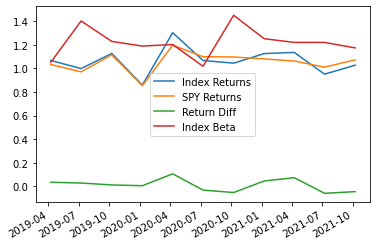

In [39]:
method1_performance = pd.DataFrame.from_dict(master_cluster_performance, orient="index")
method1_performance.loc[(8,), :].plot()
# plt.savefig("./output/method1_performance_plot.png")

In [40]:
# method1_performance.to_csv("./output/method1_performance.csv")

In [41]:
method2_index = pd.DataFrame.from_dict(master_mean_var_index, orient="index")
method2_index

weight
5  2019-04-08 EXC   0.092001
              HON   0.487535
              JPM   0.003689
              MA    0.325308
              MDLZ  0.091467
...                      ...
19 2021-10-08 SO    0.000002
              T     0.000002
              TMUS  0.000228
              TSLA  0.128751
              XOM   0.060612

[1931 rows x 1 columns]

In [42]:
method2_index.loc[
    (11, method1_index.index.get_level_values(1)[-1], ), :
]

,weight
AVGO,4.909352e-02
CMCSA,2.717491e-09
FDX,9.212596e-10
HD,3.923276e-08
JNJ,3.348646e-09
MA,2.647938e-09
MDLZ,2.895289e-09
MET,5.245612e-01
MSFT,4.263451e-01
RTX,1.303002e-07


In [43]:
# method2_index.to_csv("./output/method2_index.csv")

<AxesSubplot:>

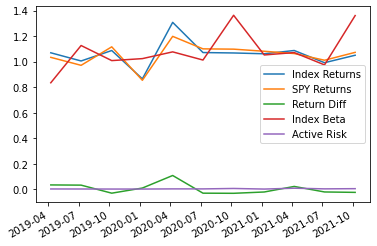

In [44]:
method2_performance = pd.DataFrame.from_dict(master_mean_var_performance, orient="index")
method2_performance.loc[(11,), :].plot()
# plt.savefig("./output/method2_performance_plot.png")

In [45]:
# method2_performance.to_csv("./output/method2_performance.csv")

In [46]:
method1_index.index.names = ['K', 'date', 'tickers']
method2_index.index.names = ['K', 'date', 'tickers']

In [47]:
comp_index = method1_index.join(
    method2_index, 
    lsuffix=" method 1", 
    rsuffix=" method 2"
)
comp_index

weight method 1  weight method 2
K  date       tickers                                  
5  2019-04-08 EXC             0.054364         0.092001
              HON             0.204875         0.487535
              JPM             0.128289         0.003689
              MA              0.532585         0.325308
              MDLZ            0.079888         0.091467
...                                ...              ...
19 2021-10-08 SO              0.012110         0.000002
              T               0.025319         0.000002
              TMUS            0.004436         0.000228
              TSLA            0.117926         0.128751
              XOM             0.054097         0.060612

[1980 rows x 2 columns]

In [48]:
# comp_index.to_csv("./output/comp_index.csv")

In [49]:
comp_performance = method1_performance.join(
    method2_performance, 
    lsuffix=" Method 1", 
    rsuffix=" Method 2"
).fillna(method="ffill")
comp_performance.index.names = ['K', "date"]
comp_performance

Index Returns Method 1  SPY Returns Method 1  \
K  date                                                       
5  2019-04-08                1.112815              1.033592   
   2019-07-08                0.964994              0.971194   
   2019-10-08                1.150798              1.115850   
   2020-01-08                0.859746              0.854093   
   2020-04-08                1.231144              1.197795   
...                               ...                   ...   
19 2020-10-08                1.051112              1.097677   
   2021-01-08                1.054109              1.081134   
   2021-04-08                1.127820              1.063307   
   2021-07-08                0.997748              1.011055   
   2021-10-08                1.085298              1.072642   

               Return Diff Method 1  Index Beta Method 1  \
K  date                                                    
5  2019-04-08              0.079223             1.069230   
   2019-07-08             -0.006199             1.311943   
   2019-10-08              0.034948             1.189172   
   2020-01-08              0.005654             1.165554   
   2020-04-08              0.033349             1.233585   
...                             ...                  ...   
19 2020-10-08             -0.046565             1.446643   
   2021-01-08             -0.027025             1.052495   
   2021-04-08              0.064513             1.219089   
   2021-07-08             -0.013307             1.169945   
   2021-10-08              0.012655             1.068957   

               Index Returns Method 2  SPY Returns Method 2  \
K  date                                                       
5  2019-04-08                1.098473              1.033592   
   2019-07-08                0.989531              0.971194   
   2019-10-08                1.167363              1.115850   
   2020-01-08                1.167363              1.115850   
   2020-04-08                1.215397              1.197795   
...                               ...                   ...   
19 2020-10-08                1.078335              1.097677   
   2021-01-08                1.059317              1.081134   
   2021-04-08                1.045120              1.063307   
   2021-07-08                0.988309              1.011055   
   2021-10-08                1.099455              1.072642   

               Return Diff Method 2  Index Beta Method 2  Active Risk  
K  date                                                                
5  2019-04-08              0.064881             0.937438     0.004239  
   2019-07-08              0.018337             1.127198     0.004056  
   2019-10-08              0.051513             1.188689     0.006644  
   2020-01-08              0.051513             1.188689     0.006644  
   2020-04-08              0.017602             1.155295     0.008440  
...                             ...                  ...          ...  
19 2020-10-08             -0.019342             1.294886     0.007527  
   2021-01-08             -0.021817             1.007167     0.003142  
   2021-04-08             -0.018186             1.239910     0.006419  
   2021-07-08             -0.022746             1.045229     0.004051  
   2021-10-08              0.026813             0.981035     0.001769  

[165 rows x 9 columns]

In [50]:
# comp_performance.to_csv("./output/comp_performance.csv")

In [51]:
return_comp_performance = comp_performance[
    ["Return Diff Method 1", "Return Diff Method 2"]
].add(1).cumprod().fillna(method="ffill")
return_comp_performance

Return Diff Method 1  Return Diff Method 2
K  date                                                  
5  2019-04-08              1.079223              1.064881
   2019-07-08              1.072533              1.084408
   2019-10-08              1.110015              1.140269
   2020-01-08              1.116291              1.199007
   2020-04-08              1.153518              1.220112
...                             ...                   ...
19 2020-10-08             15.268025              1.893140
   2021-01-08             14.855410              1.851838
   2021-04-08             15.813781              1.818160
   2021-07-08             15.603348              1.776805
   2021-10-08             15.800816              1.824446

[165 rows x 2 columns]

In [52]:
comp_performance.loc[11]

,Index Returns Method 1,SPY Returns Method 1,Return Diff Method 1,Index Beta Method 1,Index Returns Method 2,SPY Returns Method 2,Return Diff Method 2,Index Beta Method 2,Active Risk
date,,,,,,,,,
2019-04-08,1.063965,1.033592,0.030372,1.053856,1.069240,1.033592,0.035648,0.834754,0.004108
2019-07-08,0.984023,0.971194,0.012830,1.338914,1.005247,0.971194,0.034053,1.126093,0.003832
2019-10-08,1.145032,1.115850,0.029182,1.198098,1.087012,1.115850,-0.028839,1.008183,0.003446
2020-01-08,0.867289,0.854093,0.013197,1.202252,0.865381,0.854093,0.011288,1.023615,0.003401
2020-04-08,1.307082,1.197795,0.109287,1.177587,1.307233,1.197795,0.109438,1.076441,0.004731
2020-07-08,1.074530,1.099994,-0.025464,1.016314,1.071145,1.099994,-0.028849,1.012509,0.004582
2020-10-08,1.049647,1.097677,-0.048030,1.464017,1.067852,1.097677,-0.029825,1.362765,0.007978
2021-01-08,1.097822,1.081134,0.016687,1.169152,1.061578,1.081134,-0.019556,1.052226,0.003322
2021-04-08,1.141693,1.063307,0.078387,1.217614,1.087145,1.063307,0.023838,1.071033,0.009980


In [53]:
# return_comp_performance.to_csv("./output/return_comp_performance.csv")

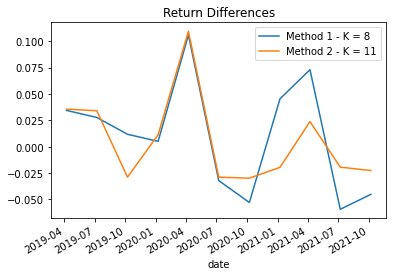

In [54]:
# comp_performance.loc[(11,), :].plot(y=["Return Diff Method 1", "Return Diff Method 2"])
# plt.savefig("./output/comp_return_plot.png")
comp_performance.loc[(8,), :]["Return Diff Method 1"].plot(label="Method 1 - K = 8")
comp_performance.loc[(11,), :]["Return Diff Method 2"].plot(label="Method 2 - K = 11")
plt.title("Return Differences")
plt.legend()

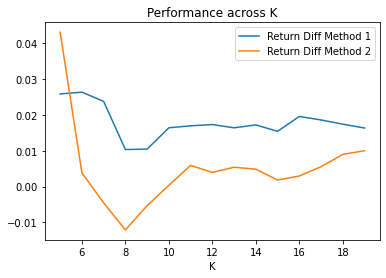

In [55]:
comp_performance.groupby(["K"]).mean().plot(y=["Return Diff Method 1", "Return Diff Method 2"])
plt.title("Performance across K")
plt.savefig("output/return_diff_K.png")

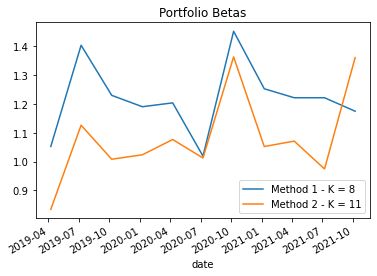

In [56]:
# comp_performance.loc[(11,), :].plot(y=["Index Beta Method 1", "Index Beta Method 2"])
# plt.savefig("./output/comp_beta_plot.png")
comp_performance.loc[(8,), :]["Index Beta Method 1"].plot(label="Method 1 - K = 8")
comp_performance.loc[(11,), :]["Index Beta Method 2"].plot(label="Method 2 - K = 11")
plt.title("Portfolio Betas")
plt.legend()

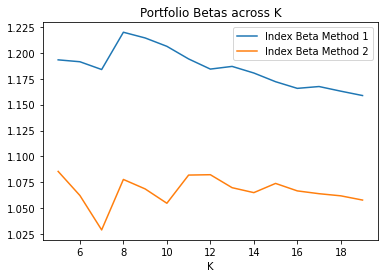

In [57]:
comp_performance.groupby(["K"]).mean().plot(y=["Index Beta Method 1", "Index Beta Method 2"])
plt.title("Portfolio Betas across K")
plt.savefig("output/beta_K.png")

In [58]:
comp_performance.loc[(8), :]

,Index Returns Method 1,SPY Returns Method 1,Return Diff Method 1,Index Beta Method 1,Index Returns Method 2,SPY Returns Method 2,Return Diff Method 2,Index Beta Method 2,Active Risk
date,,,,,,,,,
2019-04-08,1.068012,1.033592,0.034419,1.052403,1.083686,1.033592,0.050094,0.860141,0.004366
2019-07-08,0.998914,0.971194,0.027720,1.403058,0.991502,0.971194,0.020308,1.128917,0.003980
2019-10-08,1.127651,1.115850,0.011801,1.229505,1.074327,1.115850,-0.041524,0.918678,0.004868
2020-01-08,0.859176,0.854093,0.005083,1.190066,0.751876,0.854093,-0.102216,1.125540,0.005800
2020-04-08,1.303718,1.197795,0.105923,1.203477,1.308734,1.197795,0.110939,1.102335,0.005798
2020-07-08,1.067923,1.099994,-0.032071,1.019035,1.058380,1.099994,-0.041614,1.019450,0.004637
2020-10-08,1.044823,1.097677,-0.052854,1.451501,1.091429,1.097677,-0.006249,1.397119,0.008207
2021-01-08,1.126532,1.081134,0.045398,1.252337,1.059491,1.081134,-0.021643,0.966644,0.010868
2021-04-08,1.136341,1.063307,0.073034,1.221160,1.064588,1.063307,0.001281,1.040913,0.010539
